In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ensembles = list(range(0,31))

In [3]:
sio2_dict = {ensemble:{} for ensemble in ensembles}
n_impact_dict = {}
for ensemble in ensembles:
    for layer in range(12):
        with open("./sio2_percent_tables/unbound_30jan2022/ensemble_{:d}_{:d}.csv".format(ensemble, layer), "r")as f:
            sio2_dict[ensemble][layer] = pd.read_csv(f).fillna(0)
    with open("./impact_probabilities_export_unbound_30jan2022/ensemble_{:d}.csv".format(ensemble), "r")as f:
        n_impact_dict[ensemble] = pd.read_csv(f).fillna(0)

In [4]:
df = sio2_dict[1][0].loc[:,[str(p) for p in range(60,71)]].sum(axis=1) / 40


In [5]:
df

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
495    0.233008
496    0.231295
497    0.230958
498    0.231295
499    0.230622
Length: 500, dtype: float64

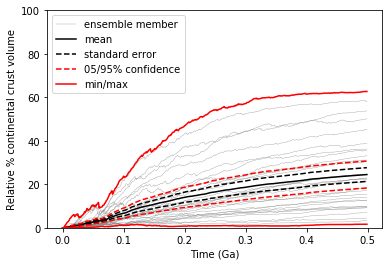

In [6]:
crust_dict = {}
for ensemble in ensembles:
    percent_bins=[]
    for p in range(60,99):
        if str(p) in list(sio2_dict[ensemble][0].columns.values):
            percent_bins.append(str(p))
    df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
    crust_dict[ensemble] = df.values
    if ensemble == 1:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey', label='ensemble member')
    else:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey')
crust_df = pd.DataFrame(crust_dict, index=df.index.values)
crust_mean = crust_df.mean(axis=1)

crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(df.index.values/1000, crust_df['mean'], c='k', label='mean')
plt.plot(df.index.values/1000, crust_df['e05'], '--', c='k', label='standard error')
plt.plot(df.index.values/1000, crust_df['e95'], '--', c='k')
plt.plot(df.index.values/1000, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(df.index.values/1000, crust_df['c95'], '--', c='r')
plt.plot(df.index.values/1000, crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(df.index.values/1000, crust_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")
plt.ylim([0,100])
plt.legend()
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_unbound.png', dpi=600)
plt.show()
plt.close()

In [7]:
final_values = {summary_characteristic:[] for summary_characteristic in ['mean', 'min', 'max',
                                                                         'standard_error', 'CI95']}
for i in range(3,len(ensembles)+1):
    crust_dict = {}
    for ensemble in ensembles[:i]:
        percent_bins=[]
        for p in range(60,100):
            if str(p) in list(sio2_dict[ensemble][0].columns.values):
                percent_bins.append(str(p))
        df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
        crust_dict[ensemble] = df.values
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    crust_mean = crust_df.mean(axis=1)
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
    crust_df['c05'] = crust_df['mean'] - standard_error * 1.96
    final_values['mean'].append(crust_df['mean'][499])
    final_values['min'].append(crust_df['min'][499])
    final_values['max'].append(crust_df['max'][499])
    final_values['standard_error'].append(standard_error[499])
    final_values['CI95'].append(standard_error[499] * 1.96)

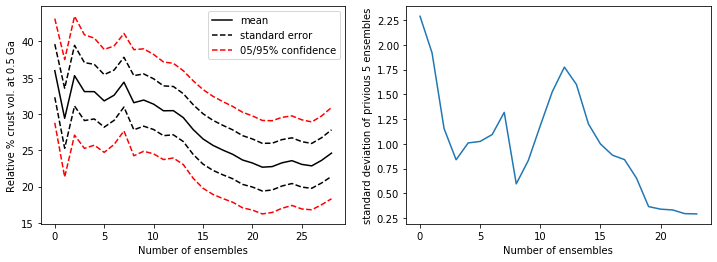

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)    
ax.plot(final_values['mean'], c='k', label='mean')
ax.plot(np.array(final_values['mean'])+np.array(final_values['standard_error']), 
         '--', c='k', label='standard error')
ax.plot(np.array(final_values['mean'])-np.array(final_values['standard_error']),'--', c='k', )
ax.plot(np.array(final_values['mean'])+np.array(final_values['CI95']), 
         '--', c='r', label='05/95% confidence')
ax.plot(np.array(final_values['mean'])-np.array(final_values['CI95']),'--', c='r', )
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("Relative % crust vol. at 0.5 Ga")
plt.legend()

std_last_5_ens = []
for i in range(5,len(final_values['mean'])):
    std_last_5_ens.append(np.std(final_values['mean'][i-5:i]))
ax = fig.add_subplot(1, 2, 2)
ax.plot(std_last_5_ens)
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("standard deviation of privious 5 ensembles")
plt.savefig('./figs/paper_figs/ensemble_convergence_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/ensemble_convergence_unbound.png', dpi=600)
plt.show()
plt.close()

In [9]:
total_impact_dict = {}
total_impact_dict['low'] = n_impact_dict[ensemble].low
total_impact_dict['high'] = n_impact_dict[ensemble].high
for ensemble in ensembles:
    total_impact_dict[ensemble] = n_impact_dict[ensemble].total

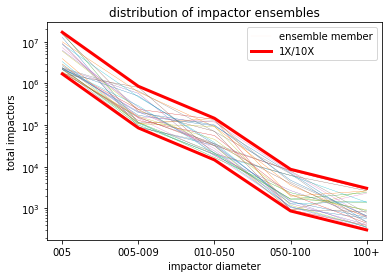

In [10]:
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(total_impact_dict[ensemble], lw=0.03, label="ensemble member")
    else:
        plt.plot(total_impact_dict[ensemble], lw=0.3)
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['low'], c='r', lw=3, label='1X/10X')
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['high'], c='r', lw=3)
plt.ylabel('total impactors')
plt.yscale('log')
plt.xlabel("impactor diameter")
plt.title("distribution of impactor ensembles")
plt.legend()
plt.savefig('./figs/paper_figs/total_impacts_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/total_impacts_unbound.png', dpi=600)
plt.show()
plt.close()

In [11]:
max_sio2_list={layer:{} for layer in range(12)}
for layer in range(11):
    for ensemble in ensembles:
        max_sio2_list[layer][ensemble]=[]
        for irow in sio2_dict[ensemble][layer].index.values:
            max_sio2_percent=0
            for icol in sio2_dict[ensemble][layer].columns.values[1:]:
                if sio2_dict[ensemble][layer].loc[irow,icol] > 0:
                    if int(icol) > max_sio2_percent:
                        max_sio2_percent = int(icol)
            max_sio2_list[layer][ensemble].append(max_sio2_percent)

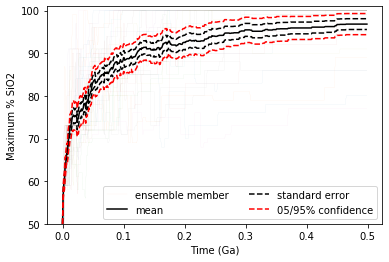

In [12]:
max_sio2_df          = pd.DataFrame(max_sio2_list[0])
max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
max_sio2_df['min']   = max_sio2_df.min(axis=1)
max_sio2_df['max']   = max_sio2_df.max(axis=1)
max_sio2_df['stdev'] = max_sio2_df.std(axis=1)
standard_error       = max_sio2_df['stdev']/np.sqrt(len(ensembles))
max_sio2_df['e05']   = max_sio2_df['mean'] - standard_error
max_sio2_df['e95']   = max_sio2_df['mean'] + standard_error
max_sio2_df['c95']   = max_sio2_df['mean'] + standard_error * 1.96
max_sio2_df['c05']   = max_sio2_df['mean'] - standard_error * 1.96
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], 
                 lw=0.03, label="ensemble member")        
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], lw=0.03)

plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], c='k', label='mean')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e05'], '--', c='k', label='standard error')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e95'], '--', c='k')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c95'], '--', c='r')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['min'].clip(lower=0), c='r', label='min/max')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,101])
plt.legend(ncol=2)
plt.savefig('./figs/paper_figs/max_sio2_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/max_sio2_unbound.png', dpi=600)
plt.show()
plt.close()

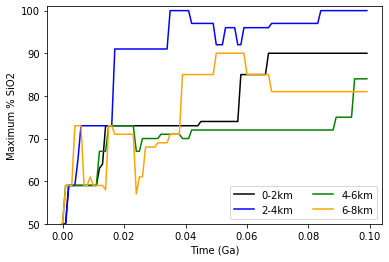

In [13]:
plt.plot(max_sio2_df.index.values[:100]/1000, max_sio2_df[0][:100], c='k', label='0-2km')
plt.plot(max_sio2_df.index.values[:100]/1000, max_sio2_df[1][:100], c='b', label='2-4km')
plt.plot(max_sio2_df.index.values[:100]/1000, max_sio2_df[2][:100], c='g', label='4-6km')
plt.plot(max_sio2_df.index.values[:100]/1000, max_sio2_df[3][:100], c='orange', label='6-8km')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,101])
plt.legend(ncol=2)
plt.savefig('./figs/paper_figs/max_sio2_layers_unbound.pdf', dpi=600)
plt.savefig('./figs/paper_figs/max_sio2_layers_unbound.png', dpi=600)
plt.show()
plt.close()